# Question 3

Can we use the database to create the model that would maximize the consumer report rating? What does that model look like and how accurate the model is?

### Step 1. Gather Data and Import Libraries
Importing database and reading the dataframe.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
df = pd.read_csv("cereal.csv")
df.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
1,100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
3,All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
4,Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843


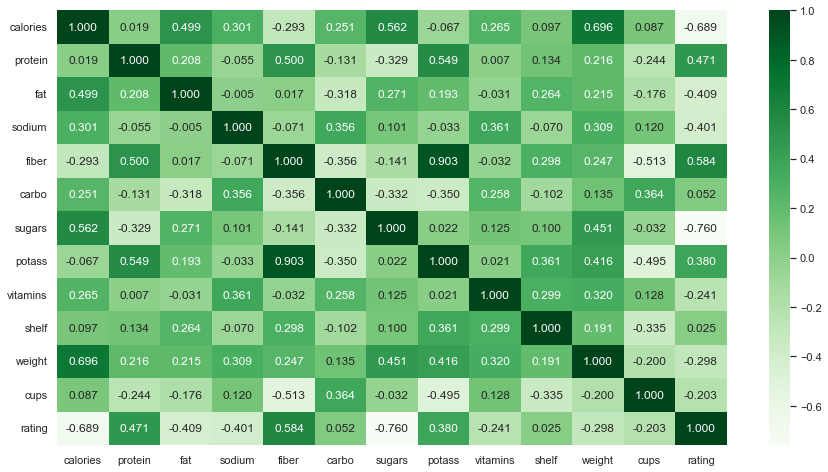

In [13]:
sns.set(rc = {'figure.figsize':(15,8)})
fig1=sns.heatmap(df.corr(), annot=True, fmt=".3f",cmap='Greens');

In [14]:
# Consider only numerical variables
num_vars = df[['calories','protein','sugars', 'fiber']]
y = df['rating']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(num_vars, y, test_size = .30, random_state=42)

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict and score the model
y_test_preds = lm_model.predict(X_test)

#Rsquared and y_test
rsquared_score = r2_score(y_test, y_test_preds)
length_y_test = len(y_test)

"The r-squared score for your model was {} on {} values.".format(rsquared_score, length_y_test)

/Users/huishi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


'The r-squared score for your model was 0.8197060582320772 on 24 values.'

In [15]:
preds_vs_act = pd.DataFrame(np.hstack([y_test.values.reshape(y_test.size,1), y_test_preds.reshape(y_test.size,1)]))
preds_vs_act.columns = ['actual', 'preds']
preds_vs_act['diff'] = preds_vs_act['actual'] - preds_vs_act['preds']
preds_vs_act.head()

,actual,preds,diff
0,34.384843,37.633399,-3.248556
1,21.871292,29.600977,-7.729685
2,18.042851,25.635583,-7.592732
3,68.402973,70.253432,-1.850459
4,34.139765,30.837636,3.302129


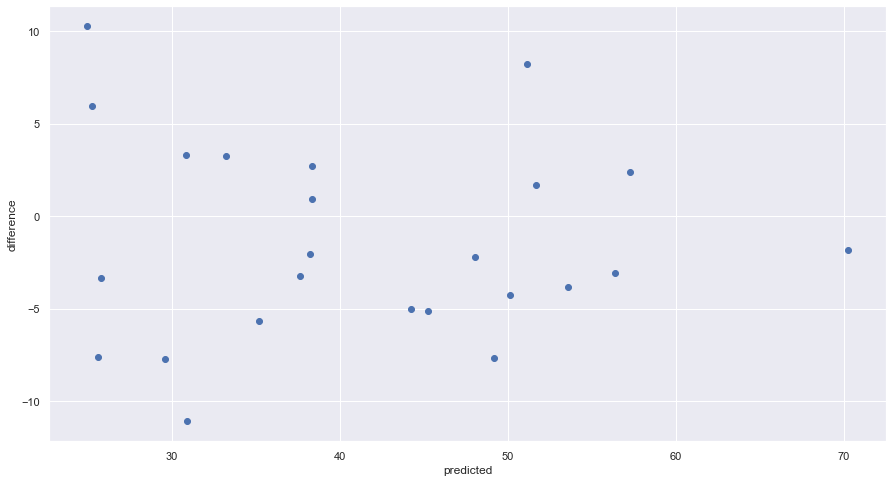

In [16]:
plt.plot(preds_vs_act['preds'], preds_vs_act['diff'], 'bo');
plt.xlabel('predicted');
plt.ylabel('difference');

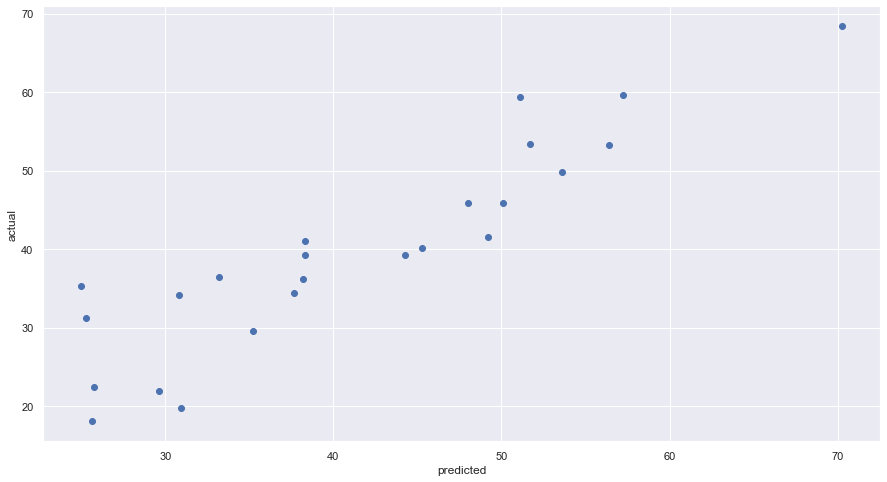

In [17]:
plt.plot(preds_vs_act['preds'], preds_vs_act['actual'], 'bo');
plt.xlabel('predicted');
plt.ylabel('actual');